In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

import utils
import multiqlearning
import qlearning
import replay
import actions
import plotting
from mangoenv import MangoEnv

In [3]:
seed = 42
map_size = 8
max_interactions = 1024*1024
map_scale = int(jnp.log2(map_size))

# hyperparams
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8
lr = 3e-4

# create base env

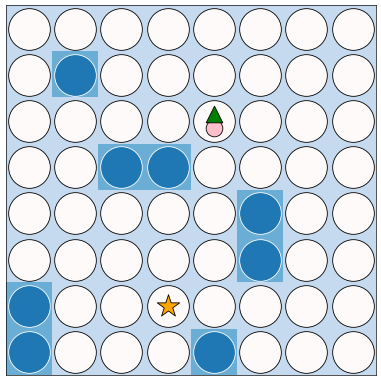

In [4]:
rng_key = jax.random.PRNGKey(seed)
rng_env, rng_layer1, rng_layer2, rng_outer = jax.random.split(rng_key, 4)
env = utils.FrozenLake.make_random(rng_env, (map_size, map_size), 0.8)
env_state, _ = env.reset(rng_key)
plotting.render(env, env_state)

# 1st mango layer

In [5]:
def setup_mango_layer(rng_key, lower_layer, cell_scale, lr, replay_capacity):
    reward_fn = actions.get_reward_fn(2**cell_scale)
    beta_fn = actions.get_beta_fn(2**cell_scale)

    lower_state, obs = lower_layer.reset(rng_key)
    action = lower_layer.action_space.sample(rng_key)
    sample_transition = utils.Transition(lower_state, obs, action, 0.0, obs, False, {})
    sample_transition = sample_transition.replace(reward=reward_fn(sample_transition))

    qnet = utils.InnerPolicyQnet(cell_scale, comands=5, actions=lower_layer.action_space.n)
    dql_state = multiqlearning.MultiDQLTrainState.create(
        rng_key, qnet, obs, lr, reward_fn=reward_fn, beta_fn=beta_fn
    )
    replay_memory = replay.CircularBuffer.create(sample_transition, replay_capacity)
    return dql_state, replay_memory

In [6]:
q_learning_step = partial(
    multiqlearning.multi_q_learning_step, rollout_length=rollout_length, train_iter=train_iter
)

rng_setup, rng_sim = jax.random.split(rng_layer1)
rng_sim = jax.random.split(rng_sim, n_rollouts)

# setup the first layer
dql_state_l1, replay_memory_l1 = setup_mango_layer(
    rng_setup, lower_layer=env, cell_scale=1, lr=lr, replay_capacity=2**14
)

# train the first layer
(env, dql_state_l1, replay_memory_l1), results = jax.lax.scan(
    q_learning_step, (env, dql_state_l1, replay_memory_l1), rng_sim
)

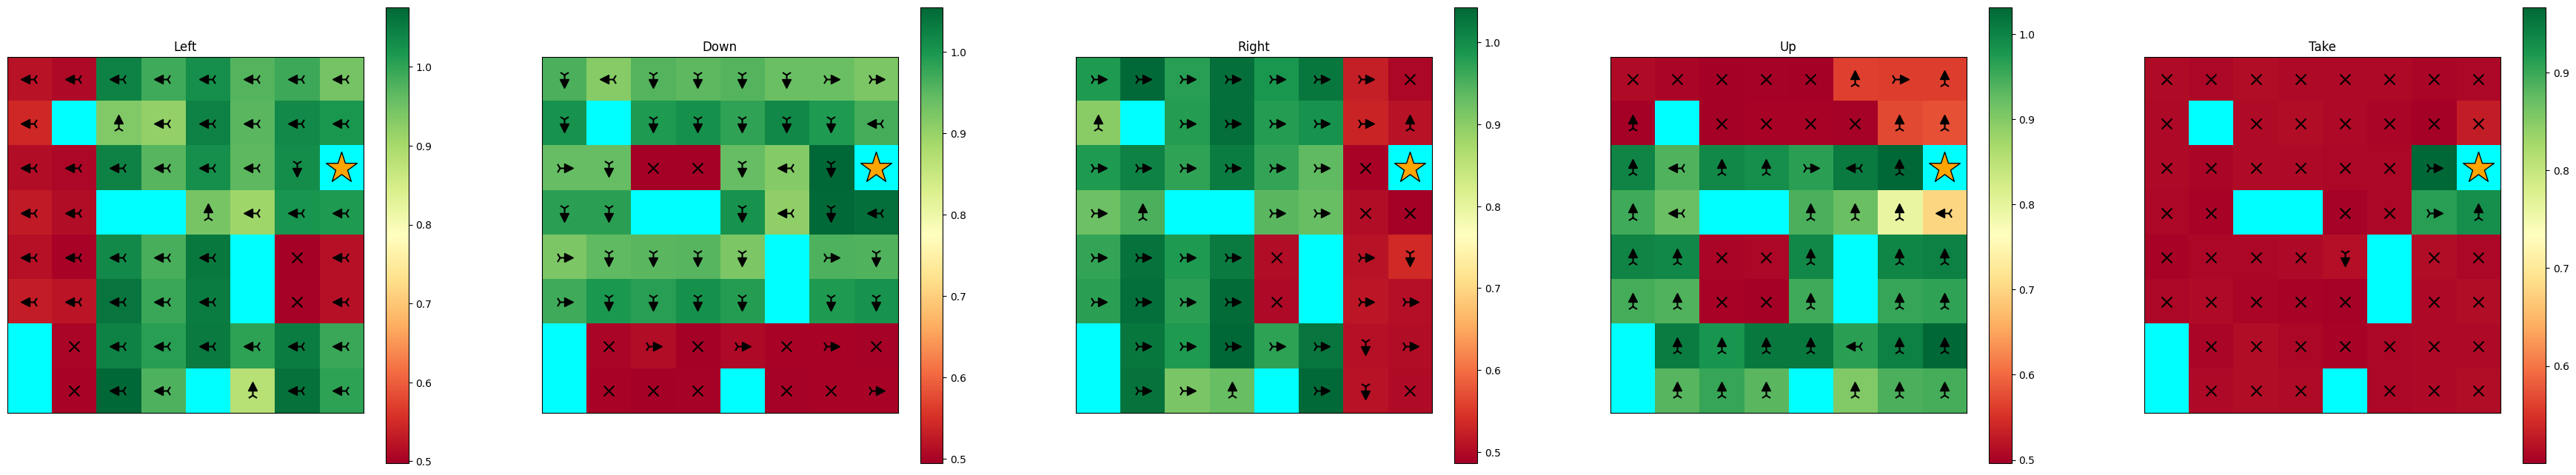

In [7]:
rng_key = jax.random.PRNGKey(0)
rng_env_reset, rng_steps = jax.random.split(rng_key)

plt.figure(figsize=((map_size + 1) * 5, map_size))
for task_id, task_name in enumerate(("Left", "Down", "Right", "Up", "Take")):
    plt.subplot(1, 5, task_id + 1)
    plt.title(task_name)
    get_qval_fn = lambda obs: dql_state_l1.qval_apply_fn(dql_state_l1.params_qnet, obs)[task_id]
    plotting.plot_qvals(env, get_qval_fn, rng_reset=rng_env_reset, hold=True)

# 2nd mango layer

In [8]:
q_learning_step = partial(
    multiqlearning.multi_q_learning_step, rollout_length=rollout_length//4, train_iter=train_iter
)

rng_setup, rng_sim = jax.random.split(rng_layer2)
rng_sim = jax.random.split(rng_sim, n_rollouts)

# setup the second layer
mango_env_l1 = MangoEnv(env, dql_state_l1, max_steps=4)
dql_state_l2, replay_memory_l2 = setup_mango_layer(
    rng_setup, lower_layer=mango_env_l1, cell_scale=2, lr=lr, replay_capacity=2**14
)

# train the second layer
(mango_env_l1, dql_state_l2, replay_memory_l2), results = jax.lax.scan(
    q_learning_step, (mango_env_l1, dql_state_l2, replay_memory_l2), rng_sim
)

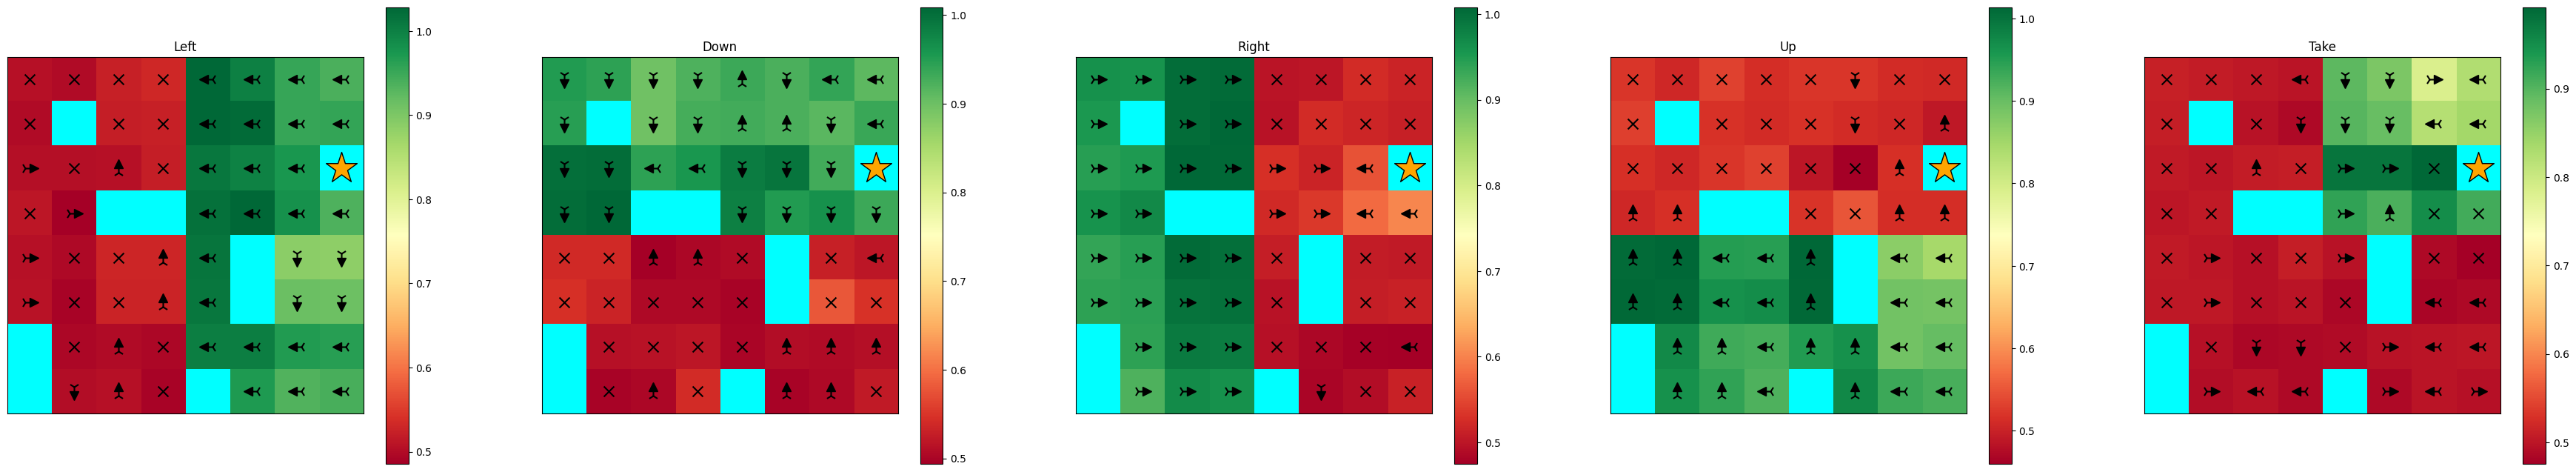

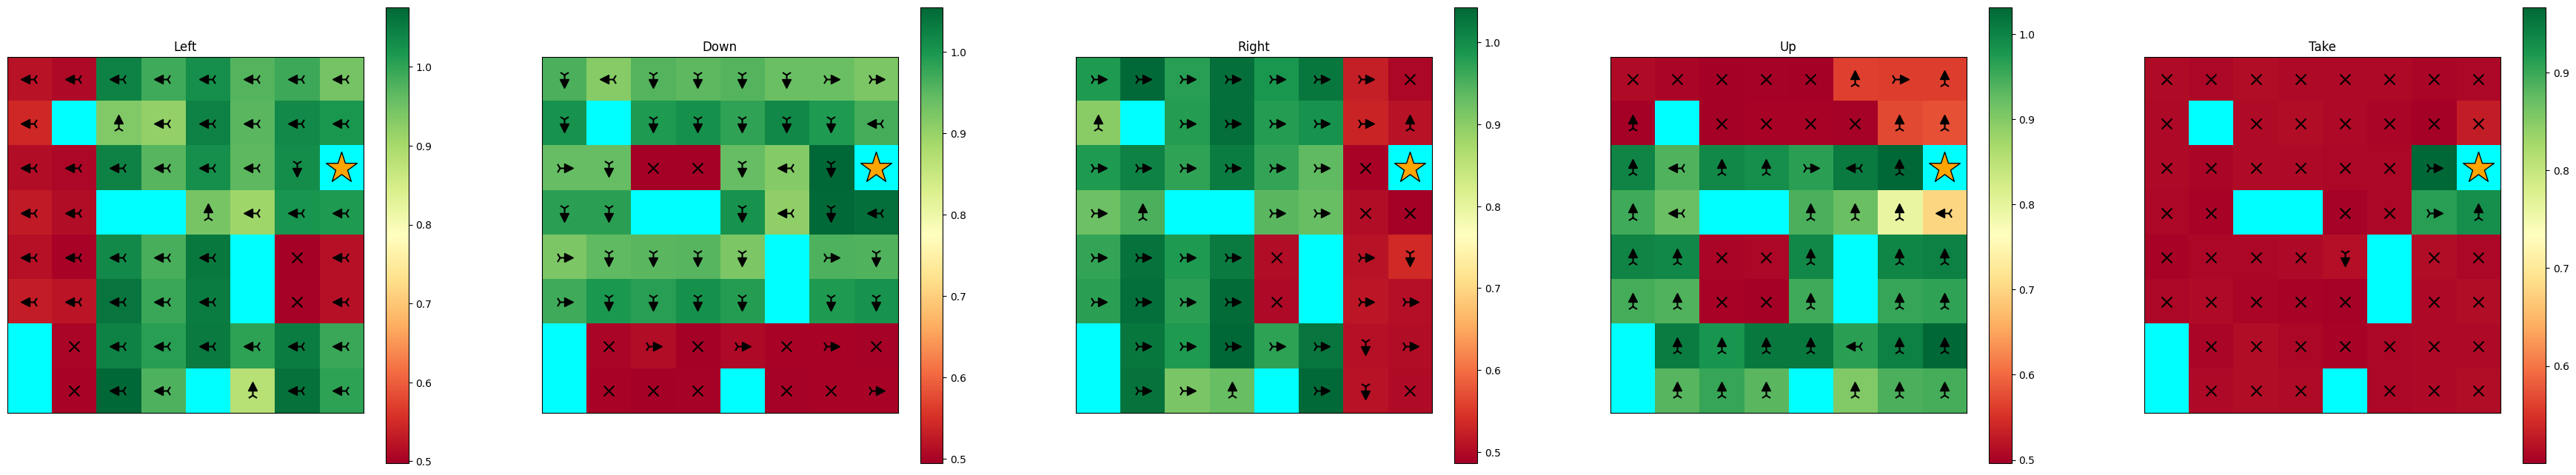

In [9]:
rng_key = jax.random.PRNGKey(0)
rng_env_reset, rng_steps = jax.random.split(rng_key)

plt.figure(figsize=((map_size + 1) * 5, map_size))
for task_id, task_name in enumerate(("Left", "Down", "Right", "Up", "Take")):
    plt.subplot(1, 5, task_id + 1)
    plt.title(task_name)
    get_qval_fn = lambda obs: dql_state_l2.qval_apply_fn(dql_state_l2.params_qnet, obs)[task_id]
    plotting.plot_qvals(env, get_qval_fn, rng_reset=rng_env_reset, hold=True)

plt.figure(figsize=((map_size + 1) * 5, map_size))
for task_id, task_name in enumerate(("Left", "Down", "Right", "Up", "Take")):
    plt.subplot(1, 5, task_id + 1)
    plt.title(task_name)
    get_qval_fn = lambda obs: dql_state_l1.qval_apply_fn(dql_state_l1.params_qnet, obs)[task_id]
    plotting.plot_qvals(env, get_qval_fn, rng_reset=rng_env_reset, hold=True)

# outer policy

In [10]:
def setup_outer_layer(rng_key, lower_layer, lr, replay_capacity):
    lower_state, obs = lower_layer.reset(rng_key)
    action = lower_layer.action_space.sample(rng_key)
    sample_transition = utils.Transition(lower_state, obs, action, 0.0, obs, False, {})

    qnet = utils.ConvNet(
        hidden=[2 * map_size] * int(np.log2(map_size)), out=lower_layer.action_space.n
    )
    dql_state = qlearning.DQLTrainState.create(rng_key, qnet, obs, lr)
    replay_memory = replay.CircularBuffer.create(sample_transition, replay_capacity)
    return dql_state, replay_memory

In [11]:
q_learning_step = partial(
    qlearning.q_learning_step, rollout_length=rollout_length//16, train_iter=train_iter
)

rng_setup, rng_sim = jax.random.split(rng_outer)
rng_sim = jax.random.split(rng_sim, n_rollouts)

# setup the outer layer
mango_env_l2 = MangoEnv(mango_env_l1, dql_state_l2, max_steps=4)
dql_state_out, replay_memory_out = setup_outer_layer(
    rng_setup, lower_layer=mango_env_l2, lr=lr, replay_capacity=2**14
)

# train the outer layer
(mango_env_l2, dql_state_out, replay_memory_out), results = jax.lax.scan(
    q_learning_step, (mango_env_l2, dql_state_out, replay_memory_out), rng_sim
)

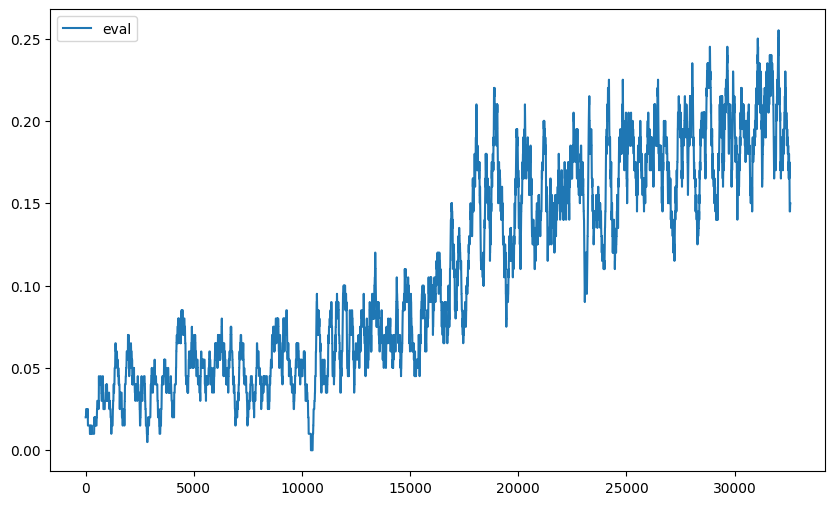

In [12]:
def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")


plt.figure(figsize=(10, 6))
r = smooth(results.eval_reward.mean(axis=-1))
plt.plot(results.eval_reward.shape[-1] * jnp.arange(1, 1 + len(r)), r, label="eval")
plt.legend()

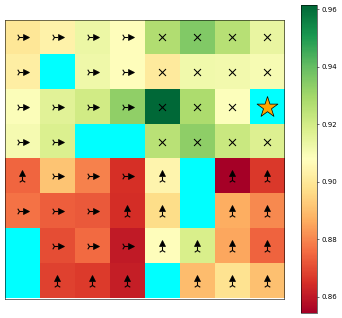

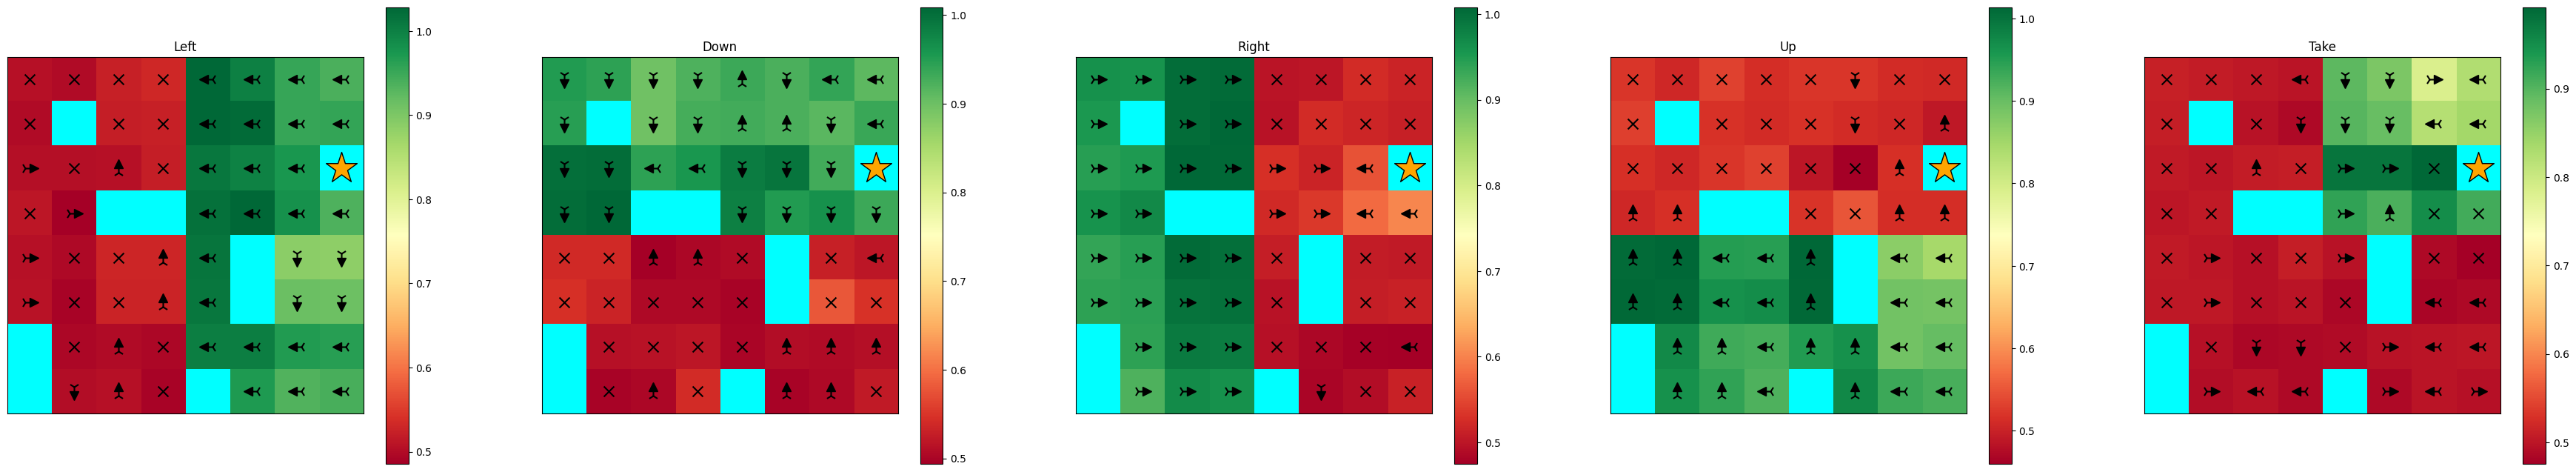

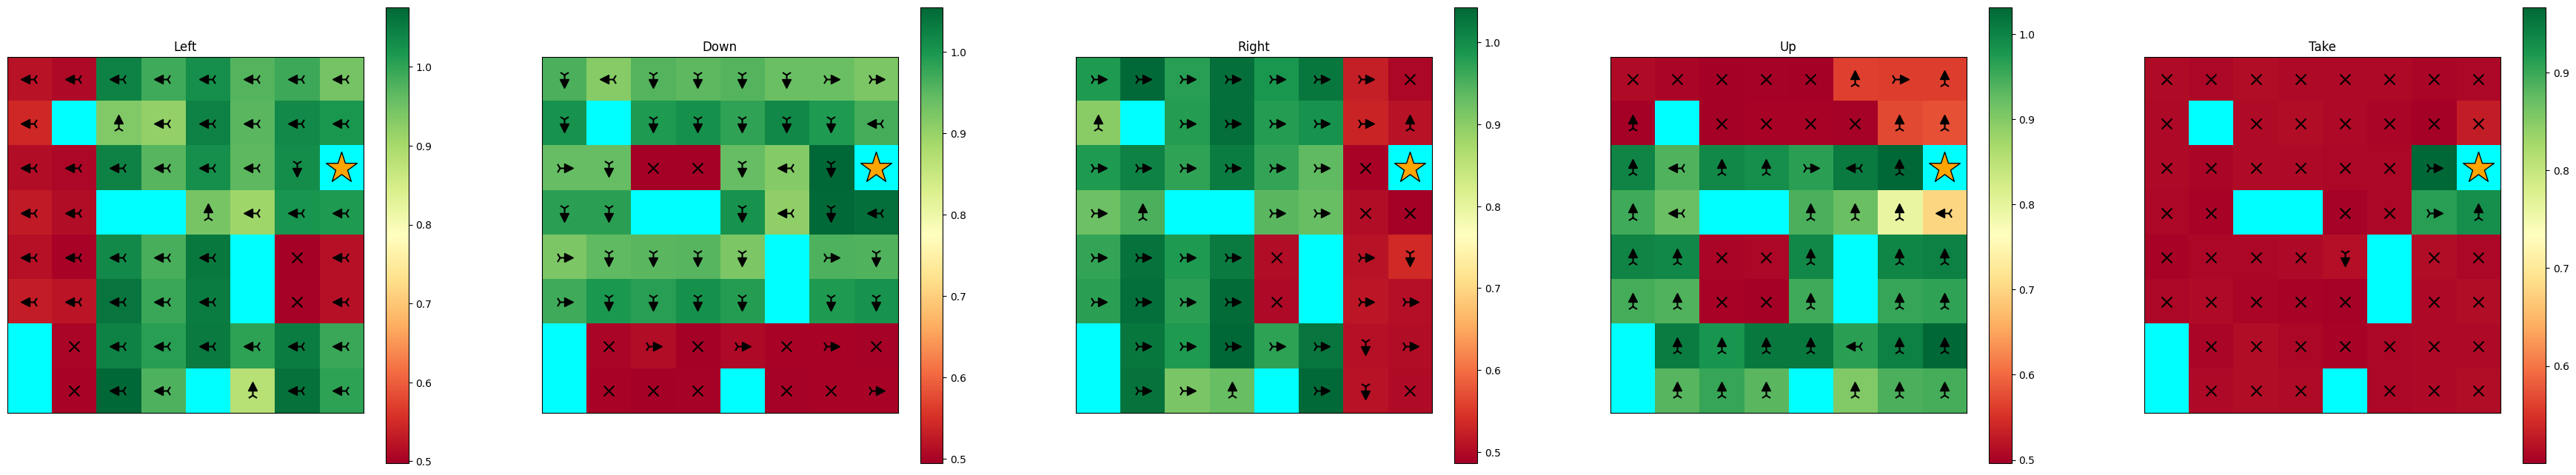

: 

In [14]:
rng_key = jax.random.PRNGKey(0)
rng_env_reset, rng_steps = jax.random.split(rng_key)

plt.figure(figsize=((map_size + 1), map_size), dpi=50)
get_qval_fn = partial(dql_state_out.qval_apply_fn, dql_state_out.params_qnet)
plotting.plot_qvals(env, get_qval_fn, rng_reset=rng_env_reset, hold=True)

plt.figure(figsize=((map_size + 1) * 5, map_size))
for task_id, task_name in enumerate(("Left", "Down", "Right", "Up", "Take")):
    plt.subplot(1, 5, task_id + 1)
    plt.title(task_name)
    get_qval_fn = lambda obs: dql_state_l2.qval_apply_fn(dql_state_l2.params_qnet, obs)[task_id]
    plotting.plot_qvals(env, get_qval_fn, rng_reset=rng_env_reset, hold=True)

plt.figure(figsize=((map_size + 1) * 5, map_size))
for task_id, task_name in enumerate(("Left", "Down", "Right", "Up", "Take")):
    plt.subplot(1, 5, task_id + 1)
    plt.title(task_name)
    get_qval_fn = lambda obs: dql_state_l1.qval_apply_fn(dql_state_l1.params_qnet, obs)[task_id]
    plotting.plot_qvals(env, get_qval_fn, rng_reset=rng_env_reset, hold=True)